# [Part.3]
## 4. Test function that process bboxes before and after executing preprocess function
- Extract valid bbox before executing preprocess function
- Pad bbox after executing preprocess function

## 5. Test reduce_min & reduce_max

### 1. Run preprocess function -- Part.1
### 2. Check function -- Part.2
### 3. Test crop_bbox code -- Part.2

In [1]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class DatasetGenerator(object):
    def __init__(self, data_dir, input_size, output_size, batch_size):
        self.data_dir = Path(data_dir)
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self._num_bbox = 0

    def run(self, train_num_bbox, val_num_bbox, preprocessed=None):
        return self.get_tfdataset(
            train=True, num_bbox=train_num_bbox,
            preprocessed=preprocessed), self.get_tfdataset(
                train=False, num_bbox=val_num_bbox)

    def get_tfdataset(self, train, num_bbox, preprocessed=None):
        self._num_bbox = num_bbox
        tfrecords_dir = self.data_dir / 'tfrecords' / f'{"train" if train else "val"}_{self.input_size}'
        tfrecords_files = [str(f) for f in tfrecords_dir.glob('*.tfrecords')]
        tfrecords = tf.data.TFRecordDataset(
            tfrecords_files, num_parallel_reads=len(tfrecords_files))
        ds = tfrecords
        if train:
            ds = ds.shuffle(buffer_size=10000, seed=42) 
        ds = ds.map(self._parse_tfrecord,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if train and preprocessed:
            
            ds = ds.map(self._extract_valid_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_float32,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            for preprocess in preprocessed:
                ds = ds.map(preprocess,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_uint8,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            ds = ds.map(self._pad_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            

        ds = ds.map(lambda i, o: (preprocess_input(tf.cast(i, tf.float32)), o),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)    

        return ds

    def _parse_tfrecord(self, tfrecord):
        tf_example = tf.io.parse_single_example(tfrecord,
                                                features={
                                                    'image_raw':
                                                    tf.io.FixedLenFeature(
                                                        (), tf.string),
                                                    'bboxes':
                                                    tf.io.FixedLenFeature(
                                                        (self._num_bbox, 4),
                                                        tf.float32)
                                                })
        image = tf.image.decode_jpeg(tf_example['image_raw'], channels=3)
        bboxes = tf_example['bboxes']
        
        return image, bboxes

    def _convert_image_float32(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.float32), bboxes

    def _convert_image_uint8(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.uint8), bboxes
    
    def _extract_valid_bboxes(self, image, bboxes):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        return image, valid_bboxes
    
    def _pad_bboxes(self, image, bboxes):
        padded_bboxes = tf.pad(bboxes,[[0, self._num_bbox - tf.shape(bboxes)[0]], [0, 0]],'CONSTANT')
        return image, padded_bboxes


In [2]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf

def draw_bbox(image, bboxes):
    plt.imshow(image)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patch = patches.Rectangle((float(x1), float(y1)), float(x2-x1), float(y2-y1), alpha=0.5)
        plt.gca().add_patch(patch)
    plt.show()
    plt.clf()

# 4. Test function that process bboxes before and after executing preprocess function¶
- the number of images: 32

In [3]:
data_dir = 'data'
input_size = 512
output_size = input_size/4
batch_size = 1

In [4]:
class DatasetGenerator_test1(object):
    def __init__(self, data_dir, input_size, output_size, batch_size):
        self.data_dir = Path(data_dir)
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self._num_bbox = 0

    def run(self, train_num_bbox, val_num_bbox, preprocessed=None):
        return self.get_tfdataset(
            train=True, num_bbox=train_num_bbox,
            preprocessed=preprocessed), self.get_tfdataset(
                train=False, num_bbox=val_num_bbox)

    def get_tfdataset(self, train, num_bbox, preprocessed=None):
        self._num_bbox = num_bbox
        tfrecords_dir = self.data_dir / 'tfrecords' / f'{"train" if train else "val"}_{self.input_size}'
        tfrecords_files = [str(f) for f in tfrecords_dir.glob('*.tfrecords')]
        tfrecords = tf.data.TFRecordDataset(
            tfrecords_files, num_parallel_reads=len(tfrecords_files))
        ds = tfrecords
        if train:
            ds = ds.shuffle(buffer_size=10000, seed=42) 
        ds = ds.map(self._parse_tfrecord,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if train and preprocessed:
            
            ds = ds.map(self._extract_valid_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_float32,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            for preprocess in preprocessed:
                ds = ds.map(preprocess,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_uint8,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
#             ds = ds.map(self._pad_bboxes,
#                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
            

        ds = ds.map(lambda i, o: (preprocess_input(tf.cast(i, tf.float32)), o),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)    

        return ds

    def _parse_tfrecord(self, tfrecord):
        tf_example = tf.io.parse_single_example(tfrecord,
                                                features={
                                                    'image_raw':
                                                    tf.io.FixedLenFeature(
                                                        (), tf.string),
                                                    'bboxes':
                                                    tf.io.FixedLenFeature(
                                                        (self._num_bbox, 4),
                                                        tf.float32)
                                                })
        image = tf.image.decode_jpeg(tf_example['image_raw'], channels=3)
        bboxes = tf_example['bboxes']
        
        return image, bboxes

    def _convert_image_float32(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.float32), bboxes

    def _convert_image_uint8(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.uint8), bboxes
    
    def _extract_valid_bboxes(self, image, bboxes):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        return image, valid_bboxes
    
    def _pad_bboxes(self, image, bboxes):
        padded_bboxes = tf.pad(bboxes,[[0, self._num_bbox - tf.shape(bboxes)[0]], [0, 0]],'CONSTANT')
        return image, padded_bboxes

class DatasetGenerator_test2(object):
    def __init__(self, data_dir, input_size, output_size, batch_size):
        self.data_dir = Path(data_dir)
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self._num_bbox = 0

    def run(self, train_num_bbox, val_num_bbox, preprocessed=None):
        return self.get_tfdataset(
            train=True, num_bbox=train_num_bbox,
            preprocessed=preprocessed), self.get_tfdataset(
                train=False, num_bbox=val_num_bbox)

    def get_tfdataset(self, train, num_bbox, preprocessed=None):
        self._num_bbox = num_bbox
        tfrecords_dir = self.data_dir / 'tfrecords' / f'{"train" if train else "val"}_{self.input_size}'
        tfrecords_files = [str(f) for f in tfrecords_dir.glob('*.tfrecords')]
        tfrecords = tf.data.TFRecordDataset(
            tfrecords_files, num_parallel_reads=len(tfrecords_files))
        ds = tfrecords
        if train:
            ds = ds.shuffle(buffer_size=10000, seed=42) 
        ds = ds.map(self._parse_tfrecord,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if train and preprocessed:
            
            ds = ds.map(self._extract_valid_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_float32,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            for preprocess in preprocessed:
                ds = ds.map(preprocess,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_uint8,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            ds = ds.map(self._pad_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            

        ds = ds.map(lambda i, o: (preprocess_input(tf.cast(i, tf.float32)), o),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)    

        return ds

    def _parse_tfrecord(self, tfrecord):
        tf_example = tf.io.parse_single_example(tfrecord,
                                                features={
                                                    'image_raw':
                                                    tf.io.FixedLenFeature(
                                                        (), tf.string),
                                                    'bboxes':
                                                    tf.io.FixedLenFeature(
                                                        (self._num_bbox, 4),
                                                        tf.float32)
                                                })
        image = tf.image.decode_jpeg(tf_example['image_raw'], channels=3)
        bboxes = tf_example['bboxes']
        
        return image, bboxes

    def _convert_image_float32(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.float32), bboxes

    def _convert_image_uint8(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.uint8), bboxes
    
    def _extract_valid_bboxes(self, image, bboxes):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        return image, valid_bboxes
    
    def _pad_bboxes(self, image, bboxes):
        padded_bboxes = tf.pad(bboxes,[[0, self._num_bbox - tf.shape(bboxes)[0]], [0, 0]],'CONSTANT')
        return image, padded_bboxes


In [5]:
def test(image, bboxes):
    return image, bboxes

### Extract valid bbox before executing preprocess function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


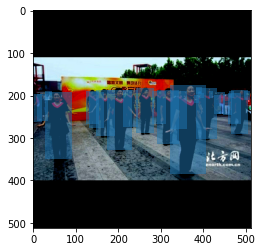

bboxes
tf.Tensor(
[[  0.       196.21036   20.474123 261.89816 ]
 [  9.383973 197.06345   34.976627 260.192   ]
 [ 28.15192  191.09181   92.13355  348.91318 ]
 [123.69783  188.53255  155.2621   267.86978 ]
 [131.37563  192.798    165.49916  277.25375 ]
 [147.5843   187.67946  191.94492  295.1686  ]
 [174.03004  185.97328  232.04007  328.43906 ]
 [211.56595  187.67946  245.68948  273.8414  ]
 [242.27713  183.41402  284.07846  287.4908  ]
 [280.6661   189.38564  313.08347  267.86978 ]
 [291.75626  187.67946  343.79465  313.93655 ]
 [324.1736   188.53255  361.7095   279.81302 ]
 [321.61435  175.73622  406.92322  384.74292 ]
 [383.0367   183.41402  431.66278  302.8464  ]
 [431.66278  191.94492  452.1369   243.13022 ]
 [447.01837  195.35727  467.4925   244.8364  ]
 [458.9616   193.6511   488.8197   267.0167  ]
 [464.93323  187.67946  506.73456  291.75626 ]
 [424.83807  197.91653  442.75293  243.13022 ]
 [ 26.445744 188.53255   45.213688 209.00668 ]
 [383.0367   179.14857  397.53925  195.357

<Figure size 432x288 with 0 Axes>

In [6]:
train_set_rot = DatasetGenerator_test1(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [test])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]    
        draw_bbox(image, valid_bboxes)
        print("bboxes")
        print(bboxes)
        print("valid_bboxes")
        print(valid_bboxes)

### Pad bbox after executing preprocess function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


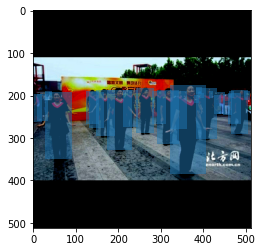

bboxes
tf.Tensor(
[[  0.       196.21036   20.474123 261.89816 ]
 [  9.383973 197.06345   34.976627 260.192   ]
 [ 28.15192  191.09181   92.13355  348.91318 ]
 ...
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]], shape=(660, 4), dtype=float32)
valid_bboxes
tf.Tensor(
[[  0.       196.21036   20.474123 261.89816 ]
 [  9.383973 197.06345   34.976627 260.192   ]
 [ 28.15192  191.09181   92.13355  348.91318 ]
 [123.69783  188.53255  155.2621   267.86978 ]
 [131.37563  192.798    165.49916  277.25375 ]
 [147.5843   187.67946  191.94492  295.1686  ]
 [174.03004  185.97328  232.04007  328.43906 ]
 [211.56595  187.67946  245.68948  273.8414  ]
 [242.27713  183.41402  284.07846  287.4908  ]
 [280.6661   189.38564  313.08347  267.86978 ]
 [291.75626  187.67946  343.79465  313.93655 ]
 [324.1736   188.53255  361.7095   279.81302 ]
 [321.61435  175.73622  406.92322  384.74292 ]
 [383.0367   183.41402  431

<Figure size 432x288 with 0 Axes>

In [7]:
train_set_rot = DatasetGenerator_test2(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [test])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]    
        draw_bbox(image, valid_bboxes)
        print("bboxes")
        print(bboxes)
        print("valid_bboxes")
        print(valid_bboxes)

# 5. Test reduce_min & reduce_max

In [8]:
import math

valid_bboxes = tf.constant([[  0.   ,    196.21036 ,  20.474123 ,261.89816 ],
 [  9.383973 ,197.06345  , 34.976627, 260.192   ],
 [ 28.15192,  191.09181 ,  92.13355 , 348.91318 ],
 [123.69783 , 188.53255  ,155.2621  , 267.86978 ],
 [131.37563  ,192.798   , 165.49916 , 277.25375 ],
 [147.5843 ,  187.67946 , 191.94492 , 295.1686  ],
 [174.03004 , 185.97328 , 232.04007  ,328.43906 ],
 [211.56595 , 187.67946 , 245.68948  ,273.8414  ],
 [242.27713 , 183.41402 , 284.07846  ,287.4908  ],
 [280.6661  , 189.38564 , 313.08347  ,267.86978 ]])

In [9]:
min_x, min_y, max_x, max_y = tf.split(value=valid_bboxes, num_or_size_splits=4, axis=1)

In [10]:
coordinate = tf.reshape(tf.concat([min_x,min_y,min_x, max_y,max_x, min_y,max_x, max_y], 1),(-1,4,2))
print(coordinate)

tf.Tensor(
[[[  0.       196.21036 ]
  [  0.       261.89816 ]
  [ 20.474123 196.21036 ]
  [ 20.474123 261.89816 ]]

 [[  9.383973 197.06345 ]
  [  9.383973 260.192   ]
  [ 34.976627 197.06345 ]
  [ 34.976627 260.192   ]]

 [[ 28.15192  191.09181 ]
  [ 28.15192  348.91318 ]
  [ 92.13355  191.09181 ]
  [ 92.13355  348.91318 ]]

 [[123.69783  188.53255 ]
  [123.69783  267.86978 ]
  [155.2621   188.53255 ]
  [155.2621   267.86978 ]]

 [[131.37563  192.798   ]
  [131.37563  277.25375 ]
  [165.49916  192.798   ]
  [165.49916  277.25375 ]]

 [[147.5843   187.67946 ]
  [147.5843   295.1686  ]
  [191.94492  187.67946 ]
  [191.94492  295.1686  ]]

 [[174.03004  185.97328 ]
  [174.03004  328.43906 ]
  [232.04007  185.97328 ]
  [232.04007  328.43906 ]]

 [[211.56595  187.67946 ]
  [211.56595  273.8414  ]
  [245.68948  187.67946 ]
  [245.68948  273.8414  ]]

 [[242.27713  183.41402 ]
  [242.27713  287.4908  ]
  [284.07846  183.41402 ]
  [284.07846  287.4908  ]]

 [[280.6661   189.38564 ]
  [280.66

In [11]:
degrees_to_radians = math.pi / 180.0
radians = 10 * degrees_to_radians
center = 511/2

rotated_bboxes = (coordinate - center) @ [[
        tf.cos(radians), -tf.sin(radians)
    ], [tf.sin(radians), tf.cos(radians)]] + center
print(rotated_bboxes)

tf.Tensor(
[[[ -6.41391   241.47821  ]
  [  4.9926453 306.16806  ]
  [ 13.749161  237.92291  ]
  [ 25.155716  302.6128   ]]

 [[  2.9756317 240.68883  ]
  [ 13.93779   302.8583   ]
  [ 28.179474  236.24472  ]
  [ 39.141632  298.41418  ]]

 [[ 20.421478  231.5489   ]
  [ 47.826874  386.9726   ]
  [ 83.43109   220.4386   ]
  [110.83647   375.8623   ]]

 [[114.07144   212.43713  ]
  [127.8482    290.56906  ]
  [145.15616   206.95605  ]
  [158.93292   285.08798  ]]

 [[122.373276  215.30457  ]
  [137.03885   298.47723  ]
  [155.9784    209.37907  ]
  [170.64398   292.55176  ]]

 [[137.44687   207.44917  ]
  [156.11218   313.30533  ]
  [181.13354   199.74603  ]
  [199.79884   305.60217  ]]

 [[163.19458   201.17667  ]
  [187.9335    341.47806  ]
  [220.32329   191.10333  ]
  [245.06221   331.40472  ]]

 [[200.4565    196.33887  ]
  [215.41837   281.19183  ]
  [234.06161   190.41339  ]
  [249.02348   275.26633  ]]

 [[229.96042   186.8053   ]
  [248.03316   289.30093  ]
  [271.12668   179.54

In [12]:
min_xy = tf.reshape(tf.reduce_min(rotated_bboxes, axis=1), (-1, 2))
print(min_xy)

tf.Tensor(
[[ -6.41391   237.92291  ]
 [  2.9756317 236.24472  ]
 [ 20.421478  220.4386   ]
 [114.07144   206.95605  ]
 [122.373276  209.37907  ]
 [137.44687   199.74603  ]
 [163.19458   191.10333  ]
 [200.4565    190.41339  ]
 [229.96042   179.54657  ]
 [268.80313   180.3908   ]], shape=(10, 2), dtype=float32)


In [13]:
max_xy = tf.reshape(tf.reduce_max(rotated_bboxes, axis=1), (-1, 2))
print(max_xy)

tf.Tensor(
[[ 25.155716 306.16806 ]
 [ 39.141632 302.8583  ]
 [110.83647  386.9726  ]
 [158.93292  290.56906 ]
 [170.64398  298.47723 ]
 [199.79884  313.30533 ]
 [245.06221  341.47806 ]
 [249.02348  281.19183 ]
 [289.19943  289.30093 ]
 [314.35663  263.3118  ]], shape=(10, 2), dtype=float32)


In [14]:
rotated_bboxes = tf.concat([min_xy, max_xy], 1)
print(rotated_bboxes)

tf.Tensor(
[[ -6.41391   237.92291    25.155716  306.16806  ]
 [  2.9756317 236.24472    39.141632  302.8583   ]
 [ 20.421478  220.4386    110.83647   386.9726   ]
 [114.07144   206.95605   158.93292   290.56906  ]
 [122.373276  209.37907   170.64398   298.47723  ]
 [137.44687   199.74603   199.79884   313.30533  ]
 [163.19458   191.10333   245.06221   341.47806  ]
 [200.4565    190.41339   249.02348   281.19183  ]
 [229.96042   179.54657   289.19943   289.30093  ]
 [268.80313   180.3908    314.35663   263.3118   ]], shape=(10, 4), dtype=float32)
